In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### Dataset Constants & Parameters

In [ ]:
TRAIN_DIR = '/content/drive/MyDrive/ProjFinal/train/'
TEST_DIR = '/content/drive/MyDrive/ProjFinal/test/'
IMAGE_SIZE = 224 # Image size of resize when applying transforms
NUM_WORKERS = 2 # Number of parallel processes for data preparation
VALID_SPLIT = 0.2 # Ratio of data for validation

train_batch_size = 32

In [ ]:
#!unzip -u "/content/drive/MyDrive/ai_ind_cv/ta/input/project-plantdoc-dataset.zip" -d "/content/drive/MyDrive/ai_ind_cv/ta/input/"
# Note:
# -u part controls extraction only if new/necessary. It is important if suddenly you lose connection or hardware switches off.
# -d creates the directory and extracted files are stored there.

In [ ]:
CLASS_NAMES = [
    'Apple Scab Leaf', 'Apple leaf', 'Apple rust leaf', 'Bell_pepper leaf',
    'Bell_pepper leaf spot', 'Blueberry leaf', 'Cherry leaf', 'Corn Gray leaf spot',
    'Corn leaf blight', 'Corn rust leaf', 'Peach leaf', 'Potato leaf early blight',
    'Potato leaf late blight', 'Raspberry leaf', 'Soyabean leaf',
    'Squash Powdery mildew leaf', 'Strawberry leaf', 'Tomato Early blight leaf',
    'Tomato Septoria leaf spot', 'Tomato leaf', 'Tomato leaf bacterial spot',
    'Tomato leaf late blight', 'Tomato leaf mosaic virus',
    'Tomato leaf yellow virus', 'Tomato mold leaf', 'grape leaf', 'grape leaf black rot'
]

### Data Transformations

In [ ]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

def get_train_transform(image_size):
    train_transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(35),
        transforms.ColorJitter(brightness=0.4,
                               contrast=0.4,
                               saturation=0.4,
                               hue=0),
        transforms.GaussianBlur(kernel_size=3, sigma=(0.5, 1.5)),
        transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
            )
    ])
    return train_transform

def get_valid_transform(image_size):
    valid_transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
            )
    ])
    return valid_transform

def get_test_transform(image_size):
    test_transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
            )
    ])
    return test_transform

### Dataset

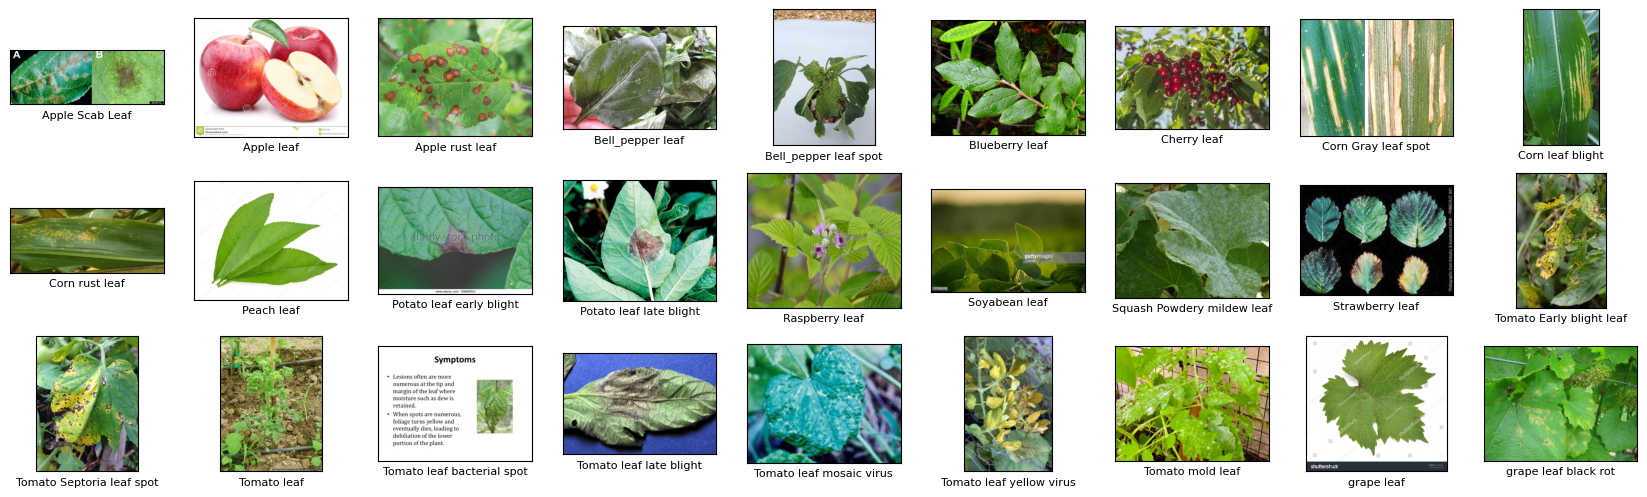

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

plt.figure(figsize=(21,6))
for i in range(0, len(CLASS_NAMES)):
    plt.subplot(3,9, i+1)
    img_name = ''.join(random.sample(os.listdir(TRAIN_DIR+CLASS_NAMES[i]),1))
    img = mpimg.imread(os.path.join(TRAIN_DIR, CLASS_NAMES[i],img_name))
    label = CLASS_NAMES[i]
    plt.imshow(img)
    plt.xlabel(label, fontsize=8)
    plt.xticks([])
    plt.yticks([])

### Data Augmentation

In [ ]:
import torchvision.transforms as T

#gray_transformation = grayscale_transform = T.Grayscale(3)
resize_transformation = T.Resize((IMAGE_SIZE, IMAGE_SIZE))
hflip_transformation = T.RandomHorizontalFlip(p=0.5)
vflip_transformation = T.RandomVerticalFlip(p=0.5)
random_rotation_transformation = T.RandomRotation(35)
gausian_blur_transformation = T.GaussianBlur(kernel_size = 3, sigma = (0.5 , 1.5))
gausian_blur_transformation2 = T.GaussianBlur(kernel_size = (7,13), sigma = (5 , 8))
colour_jitter_transformation = T.ColorJitter(brightness=(0.4),
                                               contrast=(0.4),
                                               saturation=(0.4),
                                               hue=(0))
colour_jitter_transformation_2 = T.ColorJitter(brightness=(0.7),contrast=(6),saturation=(0.9),hue=(-0.1,0.1))
normalize_transformation = T.Compose([T.ToTensor(), T.Normalize(mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225])])
sharpness_transformation = T.RandomAdjustSharpness(sharpness_factor=2, p=0.5)

In [ ]:
from PIL import Image

img_name = os.listdir(TRAIN_DIR+CLASS_NAMES[0])[5]
np_img = mpimg.imread(os.path.join(TRAIN_DIR, CLASS_NAMES[0],img_name))

def trf_img(img):
    orig_img = Image.fromarray(np_img.astype('uint8'), 'RGB')
    #gray_img=grayscale_transform(orig_img)
    resize_img = resize_transformation(orig_img)
    h_img = hflip_transformation(orig_img)
    v_img = vflip_transformation(orig_img)
    rotation_img=random_rotation_transformation(orig_img)
    gausianblured_img = gausian_blur_transformation(orig_img)
    cjitter_img= colour_jitter_transformation(orig_img)
    normalize_img = normalize_transformation(orig_img)
    sharp_img = sharpness_transformation(orig_img)
    return [orig_img, resize_img, h_img, v_img, rotation_img,
            gausianblured_img, cjitter_img, sharp_img]

transform_img = trf_img(np_img)

'\nax8= fig.add_subplot(gs[2, 3])\nax8.set_title(trf_name[8])\nax8.imshow(transform_img[8])\nax8.set_xticks([])\nax8.set_yticks([])\n'

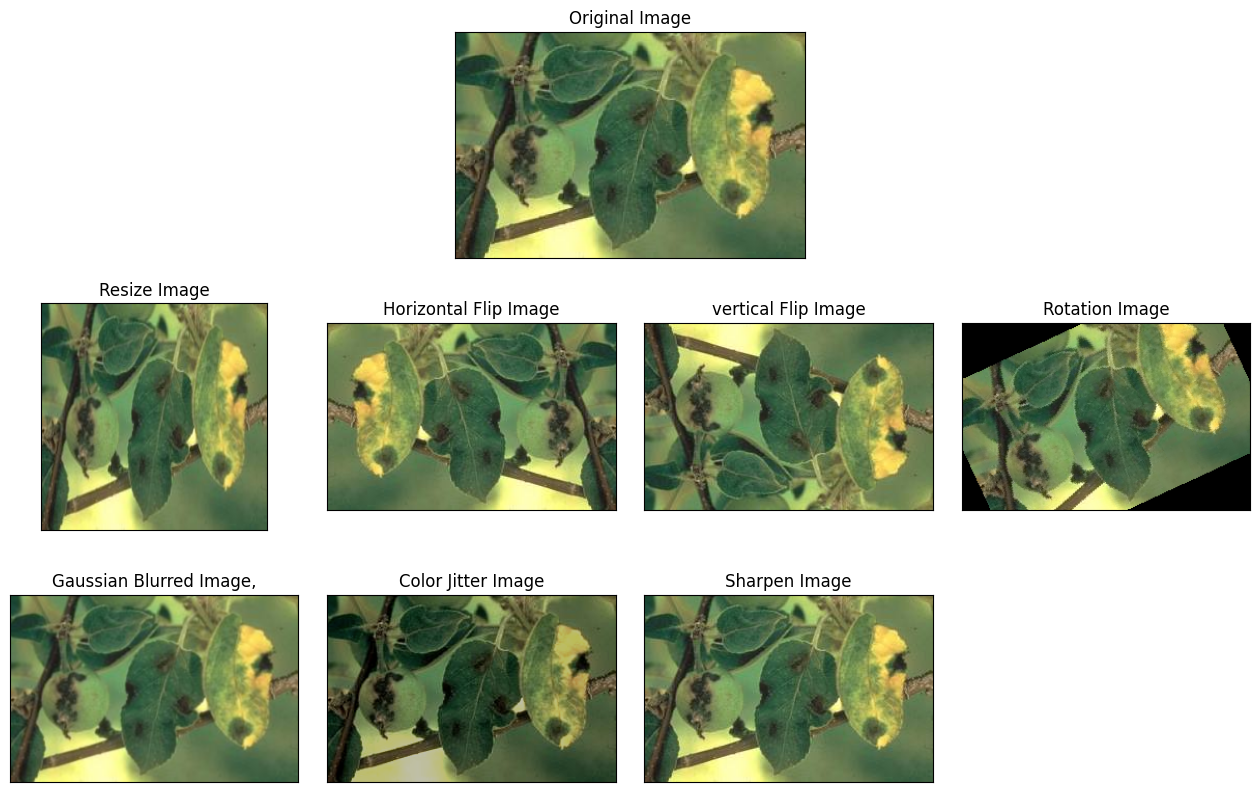

In [ ]:
import matplotlib.gridspec as grd

trf_name = ['Original Image', #'Grayscale Image',
            'Resize Image',
            'Horizontal Flip Image', 'vertical Flip Image',
            'Rotation Image', 'Gaussian Blurred Image,',
            'Color Jitter Image', 'Sharpen Image']
fig = plt.figure(figsize=(16, 10))
gs = grd.GridSpec(3, 4, wspace=0.1, hspace=0.2)
ax0= fig.add_subplot(gs[0, :])
ax0.imshow(transform_img[0])
ax0.set_title(trf_name[0])
ax0.set_xticks([])
ax0.set_yticks([])
# for i in range(len(transform_img)):
#   if i == 0:
#     ax0= fig.add_subplot(gs[0, :])
#     ax0.imshow(transform_img[0])
#     ax0.set_title(trf_name[i])
#     ax0.set_xticks([])
#     ax0.set_yticks([])
#   else:
#     ax[i]= fig.add_subplot(gs[1, i-1])
#     ax[i].imshow(transform_img[i])
#     ax[i].set_xticks([])
#     ax[i].set_yticks([])

ax1= fig.add_subplot(gs[1, 0])
ax1.set_title(trf_name[1])
ax1.imshow(transform_img[1])
ax1.set_xticks([])
ax1.set_yticks([])

ax2= fig.add_subplot(gs[1, 1])
ax2.set_title(trf_name[2])
ax2.imshow(transform_img[2])
ax2.set_xticks([])
ax2.set_yticks([])

ax3= fig.add_subplot(gs[1, 2])
ax3.set_title(trf_name[3])
ax3.imshow(transform_img[3])
ax3.set_xticks([])
ax3.set_yticks([])

ax4= fig.add_subplot(gs[1, 3])
ax4.set_title(trf_name[4])
ax4.imshow(transform_img[4])
ax4.set_xticks([])
ax4.set_yticks([])

ax5= fig.add_subplot(gs[2, 0])
ax5.set_title(trf_name[5])
ax5.imshow(transform_img[5])
ax5.set_xticks([])
ax5.set_yticks([])

ax6= fig.add_subplot(gs[2, 1])
ax6.set_title(trf_name[6])
ax6.imshow(transform_img[6])
ax6.set_xticks([])
ax6.set_yticks([])

ax7= fig.add_subplot(gs[2, 2])
ax7.set_title(trf_name[7])
ax7.imshow(transform_img[7])
ax7.set_xticks([])
ax7.set_yticks([])

"""
ax8= fig.add_subplot(gs[2, 3])
ax8.set_title(trf_name[8])
ax8.imshow(transform_img[8])
ax8.set_xticks([])
ax8.set_yticks([])
"""

### Image with Noise

#Dataset

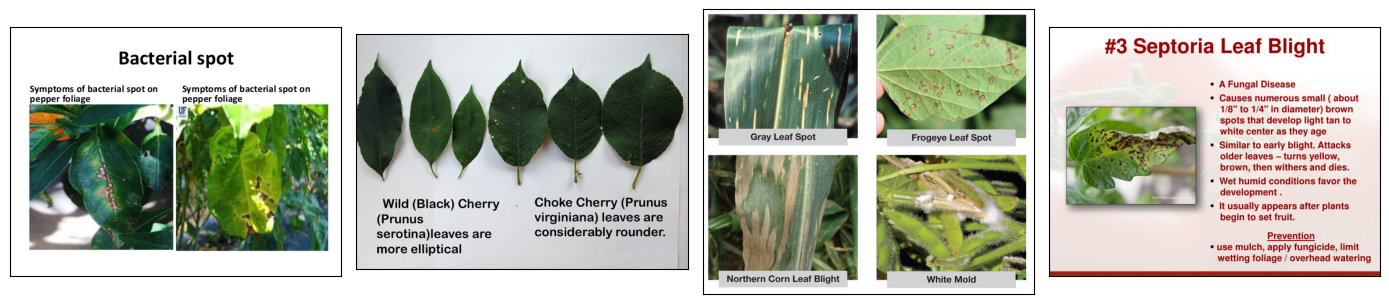

In [ ]:
img_name = ['Bell_pepper leaf spot (3).jpg', 'Cherry leaf (45).jpg', 'Corn Gray leaf spot (27).jpg', 'Tomato Septoria leaf spot (3).jpg']
plt.figure(figsize=(14,6))
for idx, name in enumerate(img_name):
    plt.subplot(1, 4, idx+1 )
    folder_name = name.split(' (')[0]
    img_name = name
    img = mpimg.imread(os.path.join(TRAIN_DIR, folder_name,img_name))
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

### Datasets and DataLoader

In [ ]:
def get_train_datasets():
    """
    Images with the same class is already grouped in its class folder.
    Therefore, datasets can be generated directly from the ImageFolder function of Dataset class.

    References:
    - https://pytorch.org/vision/stable/datasets.html
    - https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html
    """

    dataset = datasets.ImageFolder(
        TRAIN_DIR,
        transform=(get_train_transform(IMAGE_SIZE))
    )
    dataset_test = datasets.ImageFolder(
        TRAIN_DIR,
        transform=(get_valid_transform(IMAGE_SIZE))
    )

    # split training dataset to training and validation dataset
    dataset_size = len(dataset)
    # Calculate the validation dataset size
    valid_size = int(VALID_SPLIT * dataset_size)
    # Radomize the data indices
    indices = torch.randperm(len(dataset)).tolist()
    # Training and validation sets
    dataset_train = Subset(dataset, indices[:-valid_size])
    dataset_valid = Subset(dataset_test, indices[-valid_size:])

    return dataset_train, dataset_valid, dataset.classes

def get_train_data_loaders(dataset_train, dataset_valid, batch_size):
    train_loader = DataLoader(
        dataset_train, batch_size=batch_size,
        shuffle=True, num_workers=NUM_WORKERS
    )
    valid_loader = DataLoader(
        dataset_valid, batch_size=batch_size,
        shuffle=False, num_workers=NUM_WORKERS
    )

    return train_loader, valid_loader

In [ ]:
test_batch_size = 1

def get_test_datasets(image_size):
    """
    Function to prepare the Datasets.
    Returns the test dataset.
    """
    dataset_test = datasets.ImageFolder(
        TEST_DIR,
        transform=(get_test_transform(image_size))
    )
    return dataset_test

def get_test_data_loader(dataset_test):
    """
    Prepares the training and validation data loaders.
    :param dataset_test: The test dataset.

    Returns the training and validation data loaders.
    """
    test_loader = DataLoader(
        dataset_test, batch_size=test_batch_size,
        shuffle=False, num_workers=NUM_WORKERS
    )
    return test_loader

### Load Data for Training

In [ ]:
# Load datasets.
dataset_train, dataset_valid, dataset_classes = get_train_datasets()
print(f"[DATASET] Training data: {len(dataset_train)} images")
print(f"[DATASET] Validation data: {len(dataset_valid)} images\n")
print(f"[DATASET] Classes: {dataset_classes}\n")

# Load data loaders.
train_loader, valid_loader = get_train_data_loaders(
    dataset_train, dataset_valid, batch_size=train_batch_size
)

[DATASET] Training data: 1853 images
[DATASET] Validation data: 463 images

[DATASET] Classes: ['Apple Scab Leaf', 'Apple leaf', 'Apple rust leaf', 'Bell_pepper leaf', 'Bell_pepper leaf spot', 'Blueberry leaf', 'Cherry leaf', 'Corn Gray leaf spot', 'Corn leaf blight', 'Corn rust leaf', 'Peach leaf', 'Potato leaf early blight', 'Potato leaf late blight', 'Raspberry leaf', 'Soyabean leaf', 'Squash Powdery mildew leaf', 'Strawberry leaf', 'Tomato Early blight leaf', 'Tomato Septoria leaf spot', 'Tomato leaf', 'Tomato leaf bacterial spot', 'Tomato leaf late blight', 'Tomato leaf mosaic virus', 'Tomato leaf yellow virus', 'Tomato mold leaf', 'grape leaf', 'grape leaf black rot']



# Model

### resnet152

In [ ]:
model_name = 'resnet152'

In [ ]:
from torchvision import models

import torch.nn as nn

def build_model(fine_tune=True, num_classes=10):
    model = models.resnet152(weights='DEFAULT')

    if fine_tune:
        print('[INFO]: Fine-tuning all layers...')
        for params in model.parameters():
            params.requires_grad = True
    else:
        print('[INFO]: Freezing hidden layers...')
        for params in model.parameters():
            params.requires_grad = False

    # Replace the last fully-connected layer to adapt the model to a new problem with a different number of output classes
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(in_features=num_ftrs, out_features=num_classes) # model.fc = nn.Linear(in_features=2048, out_features=num_classes)

    return model

In [ ]:
# Device
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}")

Computation device: cuda


In [ ]:
# Transfer learning setting
fine_tune = True
# Note
# True for fine-tuning all layers
# False for freezing hidden layers

In [ ]:
# Load the model.
model = build_model(fine_tune=fine_tune, num_classes=len(dataset_classes)).to(device)

print(model)

Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /root/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth
100%|██████████| 230M/230M [00:01<00:00, 149MB/s]


[INFO]: Fine-tuning all layers...
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 25

In [ ]:
!pip install torchinfo

In [ ]:
from torchinfo import summary
summary(model, input_size=(train_batch_size, 3, IMAGE_SIZE, IMAGE_SIZE))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 27]                  --
├─Conv2d: 1-1                            [32, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        128
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 256, 56, 56]         --
│    └─Bottleneck: 2-1                   [32, 256, 56, 56]         --
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]          4,096
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-3                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-5             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-6                    [32, 64, 56, 56]          --
│ 

In [ ]:
# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model.parameters())
print(f"[MODEL] {total_params:,} total parameters.")

total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"[MODEL] {total_trainable_params:,} trainable parameters.")

[MODEL] 58,199,131 total parameters.
[MODEL] 58,199,131 trainable parameters.


# Training

### Directory for Outputs

In [ ]:
from datetime import datetime
import pytz

jkt_tz = pytz.timezone('Asia/Jakarta')
now_jkt = datetime.now(jkt_tz)
str_jkt = now_jkt.strftime("%y-%m-%d_%H.%M")

# Create a directory with the model name for outputs.
out_dir = os.path.join(f'/content/drive/MyDrive/ProjFinal/outputs/{str_jkt}', model_name)

os.makedirs(out_dir, exist_ok=True)

### Utilities

In [ ]:
matplotlib.style.use('ggplot')

class SaveBestModel:
    """
    Class to save the best model while training. If the current epoch's
    validation loss is less than the previous least less, then save the
    model state.
    """
    def __init__(self, best_valid_loss=float('inf'), best_valid_acc=float('inf'), best_train_loss=float('inf'), best_train_acc=float('inf'), best_epoch=0):
        self.best_valid_loss = best_valid_loss
        self.best_valid_acc = best_valid_acc
        self.best_train_loss = best_train_loss
        self.best_train_acc = best_train_acc
        self.best_epoch = best_epoch

    def __call__(self, current_valid_loss, current_valid_acc, current_train_loss, current_train_acc, epoch, model, out_dir):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            self.best_valid_acc = current_valid_acc
            self.best_train_loss = current_train_loss
            self.best_train_acc = current_train_acc
            self.best_epoch = epoch
            print(f"\nBest validation loss: {self.best_valid_loss}")
            print(f"\nSaving best model for epoch: {epoch+1}\n")
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                }, os.path.join(out_dir, 'best_model.pth'))

def save_model(epochs, model, optimizer, criterion, out_dir):
    """
    Function to save the trained model to disk.
    """
    torch.save({
                'epoch': epochs,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, os.path.join(out_dir, 'model.pth'))

def save_plots(train_acc, valid_acc, train_loss, valid_loss, out_dir):
    """
    Function to save the loss and accuracy plots to disk.
    """
    # Accuracy plots.
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_acc, color='tab:blue', linestyle='-',
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='tab:red', linestyle='-',
        label='validation accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(os.path.join(out_dir, 'accuracy.png'))

    # Loss plots.
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='tab:blue', linestyle='-',
        label='train loss'
    )
    plt.plot(
        valid_loss, color='tab:red', linestyle='-',
        label='validation loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(os.path.join(out_dir, 'loss.png'))

### Training & Validation Function

In [ ]:
import torch.optim as optim

from tqdm.auto import tqdm

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

# Training function.
def train(model, trainloader, optimizer, criterion):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # Forward pass.
        outputs = model(image)
        # Calculate the loss.
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        # Calculate the accuracy.
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        # Backpropagation.
        loss.backward()
        # Update the weights.
        optimizer.step()

    # Loss and accuracy for the complete epoch.
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    return epoch_loss, epoch_acc

# Validation function.
def validate(model, testloader, criterion, class_names):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0

    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1

            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            # Forward pass.
            outputs = model(image)
            # Calculate the loss.
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            # Calculate the accuracy.
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()

    # Loss and accuracy for the complete epoch.
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))
    return epoch_loss, epoch_acc

### Parameters

In [ ]:
epochs = 50

_learning_rate = 0.01

optimizer = optim.SGD(model.parameters(), lr=_learning_rate, momentum=0.9)
# optimizer = optim.Adam(params=model.parameters(), lr=_learning_rate)

"""
The most common hyperparameters for the Adam optimizer
- params (iterable) – iterable of parameters to optimize or dicts defining parameter groups
- Learning rate (lr): controls the step size at each iteration during gradient descent. Default: 1e-3
  A more significant learning rate can help the optimizer converge faster but may also cause it to overshoot the optimal solution.
- Beta1 (beta_1): controls the exponential decay rate for the first moment estimates. Default: 0.9
  It is typically set to 0.9 but can be adjusted to a trade-off between stability and responsiveness.
- Beta2 (beta_2): controls the exponential decay rate for the second-moment estimates. Default: 0.999
  It is typically set to 0.999 but can be adjusted to a trade-off between stability and responsiveness.
- Epsilon (epsilon): a small constant added to the denominator to avoid division by zero. Default: 1e-08
- Decay (decay): controls the learning rate decay over time.
  It is typically set to 0, meaning the learning rate remains constant.

References:
https://pytorch.org/docs/stable/generated/torch.optim.Adam.html
https://www.analyticsvidhya.com/blog/2023/12/adam-optimizer/
https://www.kdnuggets.com/2022/12/tuning-adam-optimizer-parameters-pytorch.html
https://spotintelligence.com/2023/03/01/adam-optimizer/
"""

print(f"[PARAMETER] Epochs: {epochs}")
print(f"[PARAMETER] Learning rate: {_learning_rate}")
print(f"[PARAMETER] Optimizer: {optimizer}")

[PARAMETER] Epochs: 50
[PARAMETER] Learning rate: 0.01
[PARAMETER] Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)


### Train

In [ ]:
# Loss function.
criterion = nn.CrossEntropyLoss()

# Initialize `SaveBestModel` class.
save_best_model = SaveBestModel()

# Lists to keep track of losses and accuracies.
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []

# Start the training.
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc = train(model, train_loader,
                                            optimizer, criterion)
    valid_epoch_loss, valid_epoch_acc = validate(model, valid_loader,
                                                criterion, dataset_classes)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    print(f"[TRAINING] loss: {train_epoch_loss:.3f}, acc: {train_epoch_acc:.3f}")
    print(f"[VALIDATION] loss: {valid_epoch_loss:.3f}, acc: {valid_epoch_acc:.3f}")
    save_best_model(valid_epoch_loss, valid_epoch_acc, train_epoch_loss, train_epoch_acc, epoch, model, out_dir)
    print('-'*50 + '\n')

print('TRAINING COMPLETE')
print(f"[EPOCH] best epoch: {save_best_model.best_epoch}")
print(f"[TRAINING] loss: {save_best_model.best_train_loss:.3f}, acc: {save_best_model.best_train_acc:.3f}")
print(f"[VALIDATION] loss: {save_best_model.best_valid_loss:.3f}, acc: {save_best_model.best_valid_acc:.3f}")

[INFO]: Epoch 1 of 50
Training


  0%|          | 0/58 [00:00<?, ?it/s]

Validation


  0%|          | 0/15 [00:00<?, ?it/s]

[TRAINING] loss: 2.567, acc: 28.332
[VALIDATION] loss: 1.865, acc: 43.197

Best validation loss: 1.8652548789978027

Saving best model for epoch: 1

--------------------------------------------------

[INFO]: Epoch 2 of 50
Training


  0%|          | 0/58 [00:00<?, ?it/s]

Validation


  0%|          | 0/15 [00:00<?, ?it/s]

[TRAINING] loss: 1.377, acc: 56.503
[VALIDATION] loss: 1.343, acc: 58.099

Best validation loss: 1.3432209610939025

Saving best model for epoch: 2

--------------------------------------------------

[INFO]: Epoch 3 of 50
Training


  0%|          | 0/58 [00:00<?, ?it/s]

Validation


  0%|          | 0/15 [00:00<?, ?it/s]

[TRAINING] loss: 0.844, acc: 73.394
[VALIDATION] loss: 1.359, acc: 61.123
--------------------------------------------------

[INFO]: Epoch 4 of 50
Training


  0%|          | 0/58 [00:00<?, ?it/s]

Validation


  0%|          | 0/15 [00:00<?, ?it/s]

[TRAINING] loss: 0.630, acc: 78.899
[VALIDATION] loss: 1.392, acc: 61.339
--------------------------------------------------

[INFO]: Epoch 5 of 50
Training


  0%|          | 0/58 [00:00<?, ?it/s]

Validation


  0%|          | 0/15 [00:00<?, ?it/s]

[TRAINING] loss: 0.479, acc: 84.404
[VALIDATION] loss: 1.301, acc: 62.419

Best validation loss: 1.3012149016062418

Saving best model for epoch: 5

--------------------------------------------------

[INFO]: Epoch 6 of 50
Training


  0%|          | 0/58 [00:00<?, ?it/s]

Validation


  0%|          | 0/15 [00:00<?, ?it/s]

[TRAINING] loss: 0.356, acc: 87.858
[VALIDATION] loss: 1.290, acc: 61.771

Best validation loss: 1.290288007259369

Saving best model for epoch: 6

--------------------------------------------------

[INFO]: Epoch 7 of 50
Training


  0%|          | 0/58 [00:00<?, ?it/s]

Validation


  0%|          | 0/15 [00:00<?, ?it/s]

[TRAINING] loss: 0.298, acc: 90.502
[VALIDATION] loss: 1.419, acc: 61.771
--------------------------------------------------

[INFO]: Epoch 8 of 50
Training


  0%|          | 0/58 [00:00<?, ?it/s]

Validation


  0%|          | 0/15 [00:00<?, ?it/s]

[TRAINING] loss: 0.229, acc: 93.578
[VALIDATION] loss: 1.557, acc: 62.203
--------------------------------------------------

[INFO]: Epoch 9 of 50
Training


  0%|          | 0/58 [00:00<?, ?it/s]

Validation


  0%|          | 0/15 [00:00<?, ?it/s]

[TRAINING] loss: 0.188, acc: 93.902
[VALIDATION] loss: 1.587, acc: 61.771
--------------------------------------------------

[INFO]: Epoch 10 of 50
Training


  0%|          | 0/58 [00:00<?, ?it/s]

Validation


  0%|          | 0/15 [00:00<?, ?it/s]

[TRAINING] loss: 0.191, acc: 94.172
[VALIDATION] loss: 1.725, acc: 60.475
--------------------------------------------------

[INFO]: Epoch 11 of 50
Training


  0%|          | 0/58 [00:00<?, ?it/s]

Validation


  0%|          | 0/15 [00:00<?, ?it/s]

[TRAINING] loss: 0.136, acc: 95.575
[VALIDATION] loss: 1.548, acc: 63.067
--------------------------------------------------

[INFO]: Epoch 12 of 50
Training


  0%|          | 0/58 [00:00<?, ?it/s]

Validation


  0%|          | 0/15 [00:00<?, ?it/s]

[TRAINING] loss: 0.116, acc: 96.384
[VALIDATION] loss: 1.665, acc: 63.715
--------------------------------------------------

[INFO]: Epoch 13 of 50
Training


  0%|          | 0/58 [00:00<?, ?it/s]

Validation


  0%|          | 0/15 [00:00<?, ?it/s]

[TRAINING] loss: 0.103, acc: 96.222
[VALIDATION] loss: 1.679, acc: 62.203
--------------------------------------------------

[INFO]: Epoch 14 of 50
Training


  0%|          | 0/58 [00:00<?, ?it/s]

Validation


  0%|          | 0/15 [00:00<?, ?it/s]

[TRAINING] loss: 0.111, acc: 96.762
[VALIDATION] loss: 1.626, acc: 64.795
--------------------------------------------------

[INFO]: Epoch 15 of 50
Training


  0%|          | 0/58 [00:00<?, ?it/s]

Validation


  0%|          | 0/15 [00:00<?, ?it/s]

[TRAINING] loss: 0.084, acc: 97.248
[VALIDATION] loss: 1.775, acc: 62.851
--------------------------------------------------

[INFO]: Epoch 16 of 50
Training


  0%|          | 0/58 [00:00<?, ?it/s]

Validation


  0%|          | 0/15 [00:00<?, ?it/s]

[TRAINING] loss: 0.082, acc: 97.625
[VALIDATION] loss: 1.536, acc: 65.011
--------------------------------------------------

[INFO]: Epoch 17 of 50
Training


  0%|          | 0/58 [00:00<?, ?it/s]

Validation


  0%|          | 0/15 [00:00<?, ?it/s]

[TRAINING] loss: 0.071, acc: 97.625
[VALIDATION] loss: 1.624, acc: 63.931
--------------------------------------------------

[INFO]: Epoch 18 of 50
Training


  0%|          | 0/58 [00:00<?, ?it/s]

Validation


  0%|          | 0/15 [00:00<?, ?it/s]

[TRAINING] loss: 0.067, acc: 98.003
[VALIDATION] loss: 1.577, acc: 64.147
--------------------------------------------------

[INFO]: Epoch 19 of 50
Training


  0%|          | 0/58 [00:00<?, ?it/s]

Validation


  0%|          | 0/15 [00:00<?, ?it/s]

[TRAINING] loss: 0.058, acc: 97.895
[VALIDATION] loss: 1.552, acc: 65.875
--------------------------------------------------

[INFO]: Epoch 20 of 50
Training


  0%|          | 0/58 [00:00<?, ?it/s]

Validation


  0%|          | 0/15 [00:00<?, ?it/s]

[TRAINING] loss: 0.072, acc: 97.733
[VALIDATION] loss: 1.595, acc: 66.307
--------------------------------------------------

[INFO]: Epoch 21 of 50
Training


  0%|          | 0/58 [00:00<?, ?it/s]

Validation


  0%|          | 0/15 [00:00<?, ?it/s]

[TRAINING] loss: 0.078, acc: 97.356
[VALIDATION] loss: 1.656, acc: 64.363
--------------------------------------------------

[INFO]: Epoch 22 of 50
Training


  0%|          | 0/58 [00:00<?, ?it/s]

Validation


  0%|          | 0/15 [00:00<?, ?it/s]

[TRAINING] loss: 0.071, acc: 97.841
[VALIDATION] loss: 1.580, acc: 65.875
--------------------------------------------------

[INFO]: Epoch 23 of 50
Training


  0%|          | 0/58 [00:00<?, ?it/s]

Validation


  0%|          | 0/15 [00:00<?, ?it/s]

[TRAINING] loss: 0.042, acc: 98.435
[VALIDATION] loss: 1.634, acc: 65.443
--------------------------------------------------

[INFO]: Epoch 24 of 50
Training


  0%|          | 0/58 [00:00<?, ?it/s]

Validation


  0%|          | 0/15 [00:00<?, ?it/s]

[TRAINING] loss: 0.039, acc: 98.651
[VALIDATION] loss: 1.630, acc: 65.011
--------------------------------------------------

[INFO]: Epoch 25 of 50
Training


  0%|          | 0/58 [00:00<?, ?it/s]

Validation


  0%|          | 0/15 [00:00<?, ?it/s]

[TRAINING] loss: 0.046, acc: 98.273
[VALIDATION] loss: 1.507, acc: 66.955
--------------------------------------------------

[INFO]: Epoch 26 of 50
Training


  0%|          | 0/58 [00:00<?, ?it/s]

Validation


  0%|          | 0/15 [00:00<?, ?it/s]

[TRAINING] loss: 0.034, acc: 98.813
[VALIDATION] loss: 1.661, acc: 66.739
--------------------------------------------------

[INFO]: Epoch 27 of 50
Training


  0%|          | 0/58 [00:00<?, ?it/s]

Validation


  0%|          | 0/15 [00:00<?, ?it/s]

[TRAINING] loss: 0.051, acc: 97.895
[VALIDATION] loss: 1.651, acc: 64.363
--------------------------------------------------

[INFO]: Epoch 28 of 50
Training


  0%|          | 0/58 [00:00<?, ?it/s]

Validation


  0%|          | 0/15 [00:00<?, ?it/s]

[TRAINING] loss: 0.040, acc: 98.597
[VALIDATION] loss: 1.695, acc: 68.035
--------------------------------------------------

[INFO]: Epoch 29 of 50
Training


  0%|          | 0/58 [00:00<?, ?it/s]

Validation


  0%|          | 0/15 [00:00<?, ?it/s]

[TRAINING] loss: 0.060, acc: 97.787
[VALIDATION] loss: 1.706, acc: 67.603
--------------------------------------------------

[INFO]: Epoch 30 of 50
Training


  0%|          | 0/58 [00:00<?, ?it/s]

Validation


  0%|          | 0/15 [00:00<?, ?it/s]

[TRAINING] loss: 0.048, acc: 98.057
[VALIDATION] loss: 1.947, acc: 66.091
--------------------------------------------------

[INFO]: Epoch 31 of 50
Training


  0%|          | 0/58 [00:00<?, ?it/s]

Validation


  0%|          | 0/15 [00:00<?, ?it/s]

[TRAINING] loss: 0.047, acc: 98.057
[VALIDATION] loss: 1.799, acc: 65.875
--------------------------------------------------

[INFO]: Epoch 32 of 50
Training


  0%|          | 0/58 [00:00<?, ?it/s]

Validation


  0%|          | 0/15 [00:00<?, ?it/s]

[TRAINING] loss: 0.035, acc: 98.597
[VALIDATION] loss: 2.016, acc: 65.227
--------------------------------------------------

[INFO]: Epoch 33 of 50
Training


  0%|          | 0/58 [00:00<?, ?it/s]

Validation


  0%|          | 0/15 [00:00<?, ?it/s]

[TRAINING] loss: 0.027, acc: 98.705
[VALIDATION] loss: 1.989, acc: 65.875
--------------------------------------------------

[INFO]: Epoch 34 of 50
Training


  0%|          | 0/58 [00:00<?, ?it/s]

Validation


  0%|          | 0/15 [00:00<?, ?it/s]

[TRAINING] loss: 0.029, acc: 98.759
[VALIDATION] loss: 1.966, acc: 62.203
--------------------------------------------------

[INFO]: Epoch 35 of 50
Training


  0%|          | 0/58 [00:00<?, ?it/s]

Validation


  0%|          | 0/15 [00:00<?, ?it/s]

[TRAINING] loss: 0.032, acc: 98.597
[VALIDATION] loss: 1.987, acc: 66.091
--------------------------------------------------

[INFO]: Epoch 36 of 50
Training


  0%|          | 0/58 [00:00<?, ?it/s]

Validation


  0%|          | 0/15 [00:00<?, ?it/s]

[TRAINING] loss: 0.029, acc: 98.543
[VALIDATION] loss: 1.961, acc: 65.443
--------------------------------------------------

[INFO]: Epoch 37 of 50
Training


  0%|          | 0/58 [00:00<?, ?it/s]

Validation


  0%|          | 0/15 [00:00<?, ?it/s]

[TRAINING] loss: 0.024, acc: 99.029
[VALIDATION] loss: 2.002, acc: 65.011
--------------------------------------------------

[INFO]: Epoch 38 of 50
Training


  0%|          | 0/58 [00:00<?, ?it/s]

Validation


  0%|          | 0/15 [00:00<?, ?it/s]

[TRAINING] loss: 0.032, acc: 98.597
[VALIDATION] loss: 1.824, acc: 65.875
--------------------------------------------------

[INFO]: Epoch 39 of 50
Training


  0%|          | 0/58 [00:00<?, ?it/s]

Validation


  0%|          | 0/15 [00:00<?, ?it/s]

[TRAINING] loss: 0.028, acc: 98.705
[VALIDATION] loss: 1.998, acc: 65.659
--------------------------------------------------

[INFO]: Epoch 40 of 50
Training


  0%|          | 0/58 [00:00<?, ?it/s]

Validation


  0%|          | 0/15 [00:00<?, ?it/s]

[TRAINING] loss: 0.023, acc: 99.029
[VALIDATION] loss: 1.988, acc: 64.795
--------------------------------------------------

[INFO]: Epoch 41 of 50
Training


  0%|          | 0/58 [00:00<?, ?it/s]

Validation


  0%|          | 0/15 [00:00<?, ?it/s]

[TRAINING] loss: 0.020, acc: 98.867
[VALIDATION] loss: 1.991, acc: 64.147
--------------------------------------------------

[INFO]: Epoch 42 of 50
Training


  0%|          | 0/58 [00:00<?, ?it/s]

Validation


  0%|          | 0/15 [00:00<?, ?it/s]

[TRAINING] loss: 0.032, acc: 98.813
[VALIDATION] loss: 1.947, acc: 65.227
--------------------------------------------------

[INFO]: Epoch 43 of 50
Training


  0%|          | 0/58 [00:00<?, ?it/s]

Validation


  0%|          | 0/15 [00:00<?, ?it/s]

[TRAINING] loss: 0.032, acc: 98.543
[VALIDATION] loss: 1.939, acc: 64.363
--------------------------------------------------

[INFO]: Epoch 44 of 50
Training


  0%|          | 0/58 [00:00<?, ?it/s]

Validation


  0%|          | 0/15 [00:00<?, ?it/s]

[TRAINING] loss: 0.024, acc: 98.921
[VALIDATION] loss: 1.988, acc: 62.851
--------------------------------------------------

[INFO]: Epoch 45 of 50
Training


  0%|          | 0/58 [00:00<?, ?it/s]

Validation


  0%|          | 0/15 [00:00<?, ?it/s]

[TRAINING] loss: 0.026, acc: 98.867
[VALIDATION] loss: 2.180, acc: 62.851
--------------------------------------------------

[INFO]: Epoch 46 of 50
Training


  0%|          | 0/58 [00:00<?, ?it/s]

Validation


  0%|          | 0/15 [00:00<?, ?it/s]

[TRAINING] loss: 0.034, acc: 98.435
[VALIDATION] loss: 2.094, acc: 65.227
--------------------------------------------------

[INFO]: Epoch 47 of 50
Training


  0%|          | 0/58 [00:00<?, ?it/s]

Validation


  0%|          | 0/15 [00:00<?, ?it/s]

[TRAINING] loss: 0.033, acc: 98.651
[VALIDATION] loss: 2.020, acc: 66.307
--------------------------------------------------

[INFO]: Epoch 48 of 50
Training


  0%|          | 0/58 [00:00<?, ?it/s]

Validation


  0%|          | 0/15 [00:00<?, ?it/s]

[TRAINING] loss: 0.028, acc: 98.705
[VALIDATION] loss: 1.977, acc: 65.443
--------------------------------------------------

[INFO]: Epoch 49 of 50
Training


  0%|          | 0/58 [00:00<?, ?it/s]

Validation


  0%|          | 0/15 [00:00<?, ?it/s]

[TRAINING] loss: 0.026, acc: 98.381
[VALIDATION] loss: 2.140, acc: 65.227
--------------------------------------------------

[INFO]: Epoch 50 of 50
Training


  0%|          | 0/58 [00:00<?, ?it/s]

Validation


  0%|          | 0/15 [00:00<?, ?it/s]

[TRAINING] loss: 0.030, acc: 98.651
[VALIDATION] loss: 2.065, acc: 63.499
--------------------------------------------------

TRAINING COMPLETE
[EPOCH] best epoch: 5
[TRAINING] loss: 0.356, acc: 87.858
[VALIDATION] loss: 1.290, acc: 61.771


### Saving Result

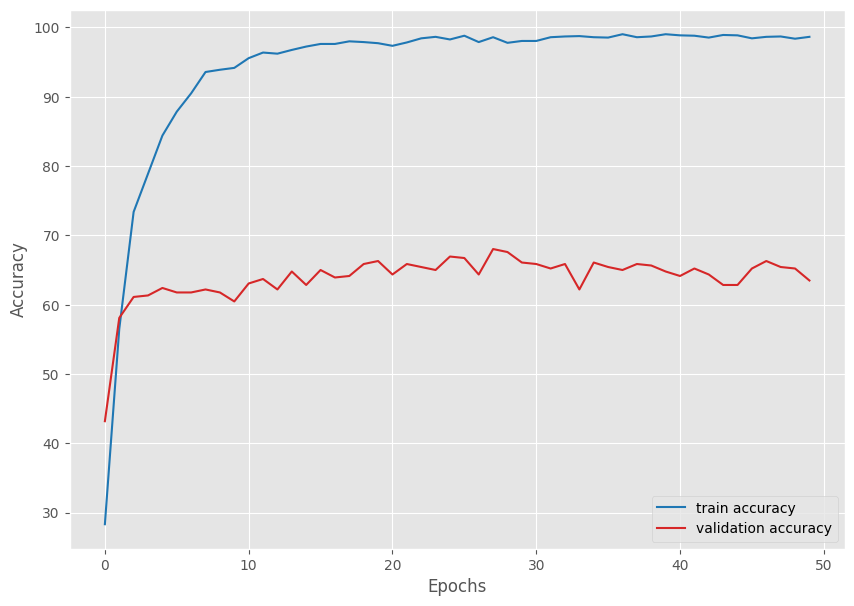

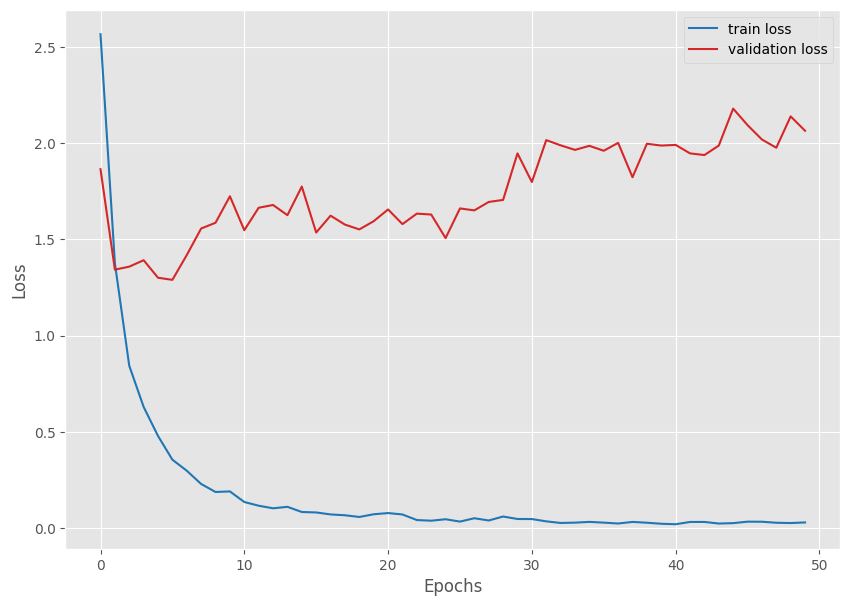

In [ ]:
# Save the trained model weights.
save_model(epochs, model, optimizer, criterion, out_dir)
# Save the loss and accuracy plots.
save_plots(train_acc, valid_acc, train_loss, valid_loss, out_dir)

# Testing

### Parameters

In [ ]:
print(str_jkt)

24-02-06_15.56


In [ ]:
from datetime import datetime
import pytz
from torchvision import models

jkt_tz = pytz.timezone('Asia/Jakarta')
now_jkt = datetime.now(jkt_tz)
str_jkt = now_jkt.strftime("%y-%m-%d_%H.%M")
model_name = 'resnet152'

In [ ]:
import pathlib
import torch

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

best_model_weights = f'/content/drive/MyDrive/ProjFinal/outputs/24-02-04_21.05/resnet152/best_model.pth'
weights_path = pathlib.Path(best_model_weights)
checkpoint = torch.load(weights_path)

### Directory for Outputs

In [ ]:
import os
#model_name = str(weights_path).split(os.path.sep)[-2]

test_result_save_dir = os.path.join(
    f'/content/drive/MyDrive/ProjFinal/outputs/{str_jkt}/test_results', model_name
)
os.makedirs(test_result_save_dir, exist_ok=True)

### Utilities

In [ ]:
import numpy as np
import cv2

def denormalize(
    x,
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
):
    for t, m, s in zip(x, mean, std):
        t.mul_(s).add_(m)
    return torch.clamp(x, 0, 1)

def save_test_results(
    tensor,
    target,
    output_class,
    counter,
    test_result_save_dir
):
    """
    This function will save a few test images along with the
    ground truth label and predicted label annotated on the image.

    :param tensor: The image tensor.
    :param target: The ground truth class number.
    :param output_class: The predicted class number.
    :param counter: The test image number.
    """
    image = denormalize(tensor).cpu()
    image = image.squeeze(0).permute((1, 2, 0)).numpy()
    image = np.ascontiguousarray(image, dtype=np.float32)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    gt = target.cpu().numpy()

    # Enlarge the image a bit to accomodate for the large class names.
    image = cv2.resize(image, (384, 384))
    cv2.putText(
        image, f"GT: {CLASS_NAMES[int(gt)]}",
        (5, 25),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.8,
        (0, 255, 0),
        2,
        cv2.LINE_AA
    )
    if output_class == gt:
        color = (0, 255, 0)
    else:
        color = (0, 0, 255)
    cv2.putText(
        image, f"Pred: {CLASS_NAMES[int(output_class)]}",
        (5, 55),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.8,
        color,
        2,
        cv2.LINE_AA
    )
    cv2.imwrite(
        os.path.join(test_result_save_dir, 'test_image_'+str(counter)+'.png'),
        image*255.
    )

### Test Function

In [ ]:
def test(model, testloader, device, test_result_save_dir):
    """
    Returns:
        predictions_list: List containing all the predicted class numbers.
        ground_truth_list: List containing all the ground truth class numbers.
        acc: The test accuracy.
    """

    model.eval()
    """
    References: https://pytorch.org/tutorials/beginner/saving_loading_models.html
    Call model.eval() to set dropout and batch normalization layers to evaluation mode before running inference.
    Failing to do this will yield inconsistent inference results.
    ----------------------------------------------------------------------------
    References: https://stackoverflow.com/questions/60018578/what-does-model-eval-do-in-pytorch
    model.eval()
    Sets model in evaluation (inference) mode:
    • normalisation layers use running statistics
    • de-activates Dropout layers
    Equivalent to model.train(False)

    model.train()
    Sets model in training mode:
    • normalisation layers1 use per-batch statistics
    • activates Dropout layers2
    """

    print('Testing model')
    predictions_list = []
    ground_truth_list = []
    test_running_correct = 0
    counter = 0

    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            # Forward pass.
            outputs = model(image)
            # Append the GT and predictions to the respective lists.
            ground_truth_list.append(labels.cpu().numpy())
            # Calculate the accuracy.
            _, preds = torch.max(outputs, 1)
            test_running_correct += (preds == labels).sum().item()
            predictions_list.append(preds.cpu().numpy())
            save_test_results(
                image,
                labels,
                preds.cpu().numpy(),
                counter,
                test_result_save_dir
            )

    acc = 100. * (test_running_correct / len(testloader.dataset))
    return predictions_list, ground_truth_list, acc

### Load Data for Testing

In [ ]:
dataset_test = get_test_datasets(IMAGE_SIZE)
print(f"[DATASET] Testing data: {len(dataset_test)} images")

test_loader = get_test_data_loader(dataset_test)

[DATASET] Testing data: 236 images


### Load the Model

In [ ]:
load_model = build_model(fine_tune=False, num_classes=len(CLASS_NAMES)).to(DEVICE)
load_model.load_state_dict(checkpoint['model_state_dict'])

[INFO]: Freezing hidden layers...


<All keys matched successfully>

### Test

In [ ]:
predictions_list, ground_truth_list, acc = test(
    load_model,
    test_loader,
    DEVICE,
    test_result_save_dir)
print(f"[TESTING] accuracy: {acc:.3f}%")

Testing model


  0%|          | 0/236 [00:00<?, ?it/s]

[TESTING] accuracy: 60.593%


# Inferences

In [ ]:
#model_name = str(weights_path).split(os.path.sep)[-2]

infer_result_path = os.path.join(
    f'/content/drive/MyDrive/ProjFinal/outputs/{str_jkt}/inference_results', model_name
)
os.makedirs(infer_result_path, exist_ok=True)

### Utilities

In [ ]:
import torch.nn.functional as F
import torchvision.transforms as transforms
import glob

def annotate_image(image, output_class):
    image = denormalize(image).cpu()
    image = image.squeeze(0).permute((1, 2, 0)).numpy()
    image = np.ascontiguousarray(image, dtype=np.float32)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    class_name = CLASS_NAMES[int(output_class)]
    plant_name = class_name.split(' ')[0]
    disease_name = ' '.join(class_name.split(' ')[1:])

    rectangle_bgr = (255, 255, 255)
    thickness = 1
    alpha = 0.2  # Transparency factor.

    font1 = cv2.FONT_HERSHEY_DUPLEX
    scale1 = 0.8
    x1, y1 = 5, 25
    w1, h1 = cv2.getTextSize(plant_name, font1, fontScale=scale1, thickness=thickness)[0]

    b1_start = (x1-2, y1+2)
    b1_end = (x1 + w1 + 2, y1 - h1 - 2)
    overlay = image.copy()
    cv2.rectangle(overlay, b1_start, b1_end, (0, 200, 0), cv2.FILLED)
    image_new = cv2.addWeighted(overlay, alpha, image, 1 - alpha, 0)

    font2 = cv2.FONT_HERSHEY_PLAIN
    scale2 = 1.0
    x2, y2 = 5, 45
    w2, h2 = cv2.getTextSize(disease_name, font2, fontScale=scale2, thickness=thickness)[0]

    b2_start = (x2-2, y2+2)
    b2_end = (x2 + w2 + 2, y2 - h2 - 2)
    overlay = image_new.copy()
    cv2.rectangle(overlay, b2_start, b2_end, (0, 200, 125), cv2.FILLED)
    image_new = cv2.addWeighted(overlay, alpha, image_new, 1 - alpha, 0)

    cv2.putText(
        image_new, plant_name, (x1, y1),
        cv2.FONT_HERSHEY_DUPLEX, scale1, (255, 0, 0), thickness,
        lineType=cv2.LINE_AA
    )

    cv2.putText(
        image_new, disease_name, (5, 45),
        cv2.FONT_HERSHEY_PLAIN, 1, (0, 0, 0), 1,
        lineType=cv2.LINE_AA
    )

    return image_new

### Transform

In [ ]:
def get_inference_transform(image_size):
    inference_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
            )
    ])
    return inference_transform

### Inferences Function

In [ ]:
def inference(model, testloader, DEVICE):
    model.eval()
    counter = 0
    with torch.no_grad():
        counter += 1
        image = testloader
        image = image.to(DEVICE)

        # Forward pass.
        outputs = model(image)

    # Softmax probabilities.
    predictions = F.softmax(outputs, dim=1).cpu().numpy()

    # Predicted class number.
    output_class = np.argmax(predictions)

    # Show and save the results.
    result = annotate_image(image, output_class)
    return result

### Load the Model

In [ ]:
load_model = build_model(fine_tune=False, num_classes=len(CLASS_NAMES)).to(DEVICE)

load_model.load_state_dict(checkpoint['model_state_dict'])

[INFO]: Freezing hidden layers...


<All keys matched successfully>

### Inferences

Image: ap_sc.jpeg


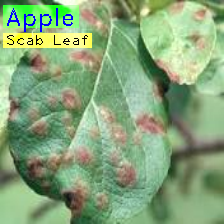



Image: co_rus.jpeg


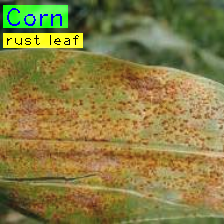



Image: co_bli.jpg


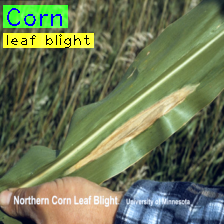



Image: co_gray_sp.jpg


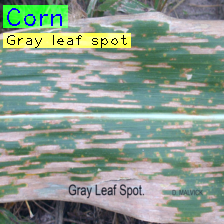



Image: sq_powd_mildew.jpeg


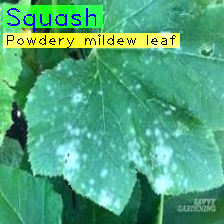



Image: tom_bact_sp.jpeg


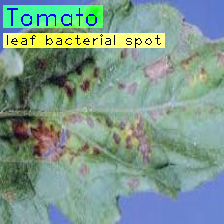



Image: ap_rus.jpeg


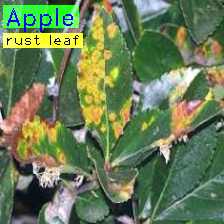



Image: bellp_sp.jpeg


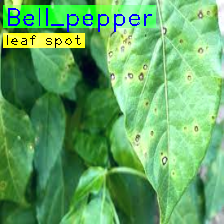



Image: tom_mos_vir.jpeg


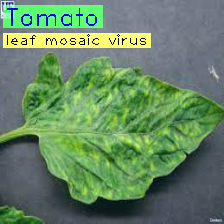



Image: tom_mold_leaf.jpeg


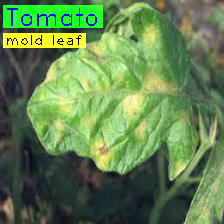



Image: pot_late_blight.jpeg


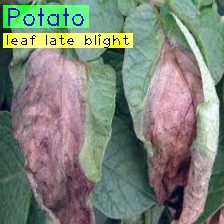



Image: gr_black_rot.jpeg


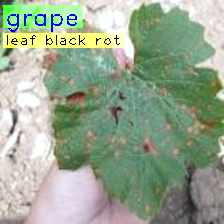

In [ ]:
from google.colab.patches import cv2_imshow

inference_image_paths = glob.glob(os.path.join('/content/drive/MyDrive/ProjFinal', 'inference_data', '*'))

transform = get_inference_transform(IMAGE_SIZE)

for i, image_path in enumerate(inference_image_paths):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = transform(image)
    image = torch.unsqueeze(image, 0)
    result = inference(load_model, image, DEVICE)

    # Save the image to disk.
    image_name = image_path.split(os.path.sep)[-1]
    print(f"Image: {image_name}")
    cv2_imshow(result*255.)
    print(f"\n")

    cv2.waitKey(1)
    cv2.imwrite(
        os.path.join(infer_result_path, image_name), result*255.
    )

# Create Summary File

In [ ]:
len_train = f"Number of training data: {len(dataset_train)}"
len_val = f"Number of validation data: {len(dataset_valid)}"
len_test = f"Number of testing data: {len(dataset_test)}"
cls = f"Classes: {dataset_classes}"

model_name = f"Model: {model_name}"
epoch = f"Epochs: {epochs}"
lr = f"Learning rate: {_learning_rate}"
opt = f"Optimizer: {optimizer}"

best_epoch = f"Best epoch: {save_best_model.best_epoch}"
best_training_loss = f"Best training loss: {save_best_model.best_train_loss:.3f}"
best_training_acc = f"Best training accuracy: {save_best_model.best_train_acc:.3f}"
best_validation_loss = f"Best validation loss: {save_best_model.best_valid_loss:.3f}"
best_validation_acc = f"Best validation accuracy: {save_best_model.best_valid_acc:.3f}"

testing_acc = f"Testing accuracy: {acc:.3f}"

import os

# Ensure the directory exists
os.makedirs(f'/content/drive/MyDrive/ProjFinal/{str_jkt}/', exist_ok=True)


fname = f'/content/drive/MyDrive/ProjFinal/{str_jkt}/{str_jkt}_summary_resnet152_50epoch_lr_01.txt'

with open(fname, mode="wt") as f:
    f.write(f'Experiment Summary\n')
    f.write(f'Date: {str_jkt}\n\n')

    f.write('-'*50 + '\n')
    f.write('Dataset\n')
    f.write('-'*50 + '\n')
    f.write(f'{len_train}\n')
    f.write(f'{len_val}\n')
    f.write(f'{len_test}\n\n')
    f.write(f'{cls}\n\n')

    f.write('-'*50 + '\n')
    f.write('Training Settings\n')
    f.write('-'*50 + '\n')
    f.write(f'{model_name}\n')
    f.write(f'{epoch}\n')
    f.write(f'{lr}\n\n')
    f.write(f'{opt}\n\n')

    f.write('-'*50 + '\n')
    f.write('Training Results\n')
    f.write('-'*50 + '\n')
    f.write(f'{best_epoch}\n')
    f.write(f'{best_training_loss}\n')
    f.write(f'{best_training_acc}\n')
    f.write(f'{best_validation_loss}\n')
    f.write(f'{best_validation_acc}\n')
    f.write(f'{testing_acc}\n')